# <center>Option Pricing Models</center>
### Kirill Zakharov
2022

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad

%matplotlib inline

plt.style.use('ggplot')

In [2]:
rvs = stats.norm.rvs(loc=0, scale=1, size=10000)

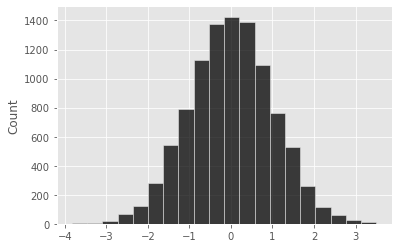

In [3]:
sns.histplot(rvs, color='black', bins=20)

plt.show()

## Main Class

In [121]:
class Stochastic_Models():
    
    def __init__(self, dividends=False):
        self.dividends = dividends
        
    def geometric_BM(self, t, initial, mu, sigma, dt):
        
        s = initial * np.exp((mu - (sigma**2)/2) * t + sigma * np.sqrt(dt) * stats.norm.rvs(loc=0, scale=1))
        
        return s
        
    def black_scholes(self, r, mu, sigma, strike, option_type='call', dividends=False, maturity=10, t=1, s0=0):
        
        if option_type == 'call':
            s = self.geometric_BM(t, s0, mu, sigma, 1)
            
            d1 = (np.log(s/strike) + (r + (sigma**2)/2) * (maturity - t)) / (sigma * np.sqrt(maturity - t))
            d2 = d1 - sigma * np.sqrt(maturity - t)
            
            c = s * stats.norm.cdf(d1, loc=0, scale=1) - strike * np.exp(-r * (maturity - t)) * stats.norm.cdf(d2, loc=0, scale=1)
        
        elif option_type == 'put':
            s = self.geometric_BM(t, initial, mu, sigma, 1)
            
            d1 = (np.log(s/strike) + (r + (sigma**2)/2) * (maturity - t)) / (sigma * np.sqrt(maturity - t))
            d2 = d1 - sigma * np.sqrt(maturity - t)
            
            c = strike * np.exp(-r * (maturity - t)) * stats.norm.cdf(-d2, loc=0, scale=1) - s * stats.norm.cdf(-d1, loc=0, scale=1)
            
        else:
            print('Incorrect type, available: call and put')
        
        return s, c
    
    def black_scholes_sim(self, r, mu, sigma, strike, option_type='call', dividends=False, maturity=10, s0=0):
        array = []
        
        for t in range(maturity):
            array.append(self.black_scholes(r, mu, sigma, strike, option_type, dividends, maturity, t, s0))
            
        return array    
    
    def heston(self, mu, theta, k, xi, rho, maturity, dt, v0, s0):
        v_array = np.zeros(maturity)
        s_array = np.zeros(maturity)
        
        v_array[0] = v0
        s_array[0] = s0
        
        for t in range(maturity - 1):
            dwv = stats.norm.rvs(loc=0, scale=1)
            dws = rho * dwv + np.sqrt(1 - rho**2) * stats.norm.rvs(loc=0, scale=1)
            
            v_array[t+1] = v_array[t] + k * (theta - v_array[t]) * dt + xi * np.sqrt(v_array[t]) * np.sqrt(dt) * dwv
            s_array[t+1] = s_array[t] + mu * s_array[t] * dt + np.sqrt(v_array[t+1]) * s_array[t] * np.sqrt(dt) * dws
            
        return s_array, v_array
    
#     def heston_option(self, muH, theta, k, xi, rho, v0, r, mu, sigma, strike, option_type='call', dividends=False, maturity=10, s0=0):
#         s, v = self.heston(muH, theta, k, xi, rho, maturity, dt, v0, s0)
#         c_array = []
        
#         for t in range(maturity):
            
#             d1 = (np.log(max(s[t]/strike, 1)) + (r + (sigma**2)/2) * (maturity - t)) / (sigma * np.sqrt(maturity - t))
#             d2 = d1 - sigma * np.sqrt(maturity - t)
            
#             c = s[t] * stats.norm.cdf(d1, loc=0, scale=1) - strike * np.exp(-r * (maturity - t)) * stats.norm.cdf(d2, loc=0, scale=1)
#             c_array.append(c)
            
#         return s, c_array   

    def heston_option(self, muH, theta, k, xi, rho, v0, r, mu, sigma, strike, option_type='call', dividends=False, maturity=10, s0=0):
        s, v = self.heston(muH, theta, k, xi, rho, maturity, dt, v0, s0)
        c_array = []
        
        for t in range(maturity):
            tau = maturity - t
            x = np.log(max(s[t], 1))
            
            u1 = 1/2
            u2 = -1/2
            
            lambda1 = 0.5
            
            b1 = k + lambda1 - rho * sigma
            b2 = k + lambda1
            
            def d_fun(tau, u, indx):
                if indx == 1:
                    d = np.sqrt((rho * sigma * u * 1j - b1)**2 - sigma**2 * (2 * u1 * u * 1j - u**2))
                    
                    g = (b1 - rho * sigma * u * 1j + d)/(b1 - rho * sigma * u * 1j - d)
                    
                    res = (b1 - rho * sigma * u * 1j + d)/(sigma**2) * ((1 - g * np.exp(d*tau))/(1 - g))
                    return res
                
                elif indx == 2:
                    d = np.sqrt((rho * sigma * u * 1j - b2)**2 - sigma**2 * (2 * u2 * u * 1j - u**2))
                    
                    g = (b2 - rho * sigma * u * 1j + d)/(b2 - rho * sigma * u * 1j - d)
                    
                    res = (b2 - rho * sigma * u * 1j + d)/(sigma**2) * ((1 - g * np.exp(d*tau))/(1 - g))
                    return res
                
                else:
                    print('Wrong Index Number')
                    
            def c_fun(tau, u, indx):
                if indx == 1:
                    d = np.sqrt((rho * sigma * u * 1j - b1)**2 - sigma**2 * (2 * u1 * u * 1j - u**2))
                    
                    g = (b1 - rho * sigma * u * 1j + d)/(b1 - rho * sigma * u * 1j - d)
                    
                    res = r * 1j * u * tau + 1/sigma**2 * ((b1 - rho * sigma * u * 1j + d)*tau - 2*np.log((1 - g * np.exp(d*tau))/(1 - g)))
                    return res
                
                elif indx == 2:
                    d = np.sqrt((rho * sigma * u * 1j - b2)**2 - sigma**2 * (2 * u2 * u * 1j - u**2))
                    
                    g = (b2 - rho * sigma * u * 1j + d)/(b2 - rho * sigma * u * 1j - d)
                    
                    res = r * 1j * u * tau + 1/sigma**2 * ((b2 - rho * sigma * u * 1j + d)*tau - 2*np.log((1 - g * np.exp(d*tau))/(1 - g)))
                    return res
                
                else:
                    print('Wrong Index Number')
            
            f1 = lambda u: np.real((np.exp(-u * np.log(strike)) * np.exp(c_fun(tau, u, 1) + d_fun(tau, u, 1) * xi + 1j * u * x))/(1j*u))
            f2 = lambda u: np.real((np.exp(-u * np.log(strike)) * np.exp(c_fun(tau, u, 2) + d_fun(tau, u, 2) * xi + 1j * u * x))/(1j*u))
            
            p1 = 1/2 + 1/np.pi * quad(f1, 0, maturity)[0] #delta
            p2 = 1/2 + 1/np.pi * quad(f2, 0, maturity)[0] #probability at-the-money
            
            c = np.exp(x) * p1 - np.exp(-r * tau) * strike * p2
            
            c_array.append(c)
            
        return s, c_array, f1, p1
    
    def simulation(self, model, maturity):
        array = []
        
        for t in range(maturity):
            array.append(model)
            
        return array
    
    def path_plot(self, values):
        
        plt.subplots(figsize=(10, 5), dpi=120)
        plt.plot(values[0], label='Underlying Asset')
        plt.plot(values[1], label='Option Price')
        
        plt.title('Path', fontsize=16)
        plt.legend()
        plt.show()

In [122]:
model = Stochastic_Models()

### Initial Parameters

In [72]:
mu = 0.1
sigma = 0.2
dt = 1
maturity = 14
r = 0.08

strike = 150
initial = 100
option_type = 'call'
dividends = False

### Simulation

In [73]:
array= []
for t in range(10):
    array.append(model.black_scholes(r, mu, sigma, strike, option_type, dividends, maturity, t, initial))
    
array = np.array(array).T

In [74]:
blackScholesSim = model.black_scholes_sim(r, mu, sigma, strike, option_type, dividends, maturity, initial)
blackScholesSim = np.array(blackScholesSim).T

### Visualisation

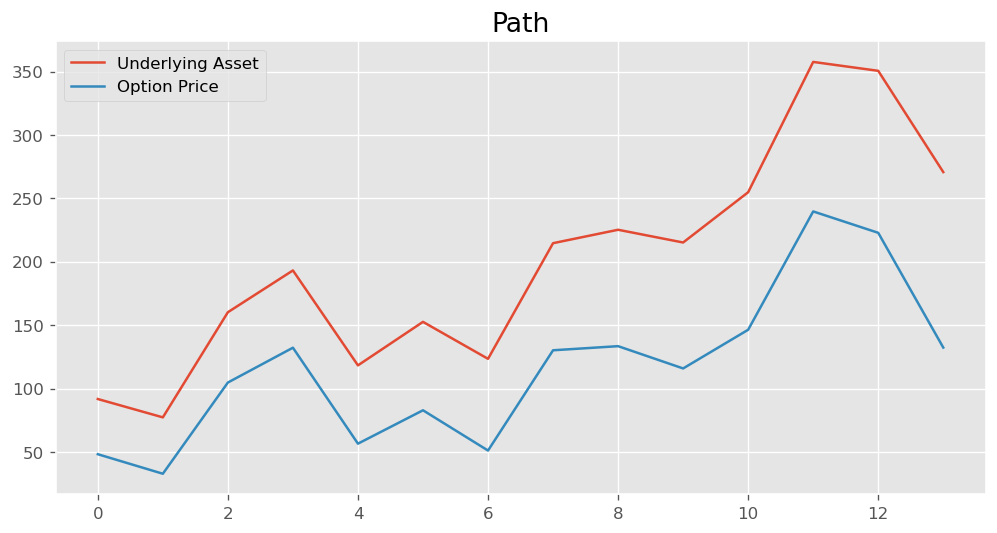

In [75]:
model.path_plot(blackScholesSim)

In [76]:
mu = 0.5
dt = 1
maturity = 14
k = 0.6
theta = 2
xi = 0.3
v0 = 0.01
s0 = 100
rho = 0.5

In [77]:
hestonSim = model.heston(mu, theta, k, xi, rho, maturity, dt, v0, s0)

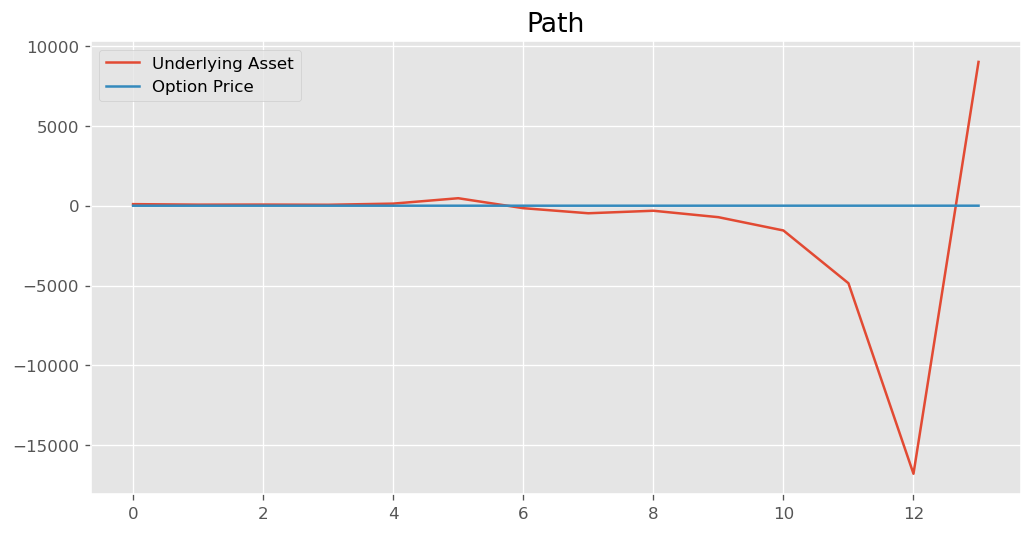

In [78]:
model.path_plot(hestonSim)

In [133]:
mu = 0.1
sigma = 0.2
r = 0.04

strike = 150
s0 = 100
option_type = 'call'
dividends = False

muH = 0.5
dt = 1
maturity = 10
k = 0.2
theta = 2
xi = 0.5
v0 = 0.01
rho = 0.5

In [134]:
hestonSim = model.heston_option(muH, theta, k, xi, rho, v0, r, mu, sigma, strike, option_type, dividends, maturity, s0)

<ipython-input-121-0bc69bcff7bf>:129: RuntimeWarning: overflow encountered in exp
  f1 = lambda u: np.real((np.exp(-u * np.log(strike)) * np.exp(c_fun(tau, u, 1) + d_fun(tau, u, 1) * xi + 1j * u * x))/(1j*u))
<ipython-input-121-0bc69bcff7bf>:129: RuntimeWarning: invalid value encountered in multiply
  f1 = lambda u: np.real((np.exp(-u * np.log(strike)) * np.exp(c_fun(tau, u, 1) + d_fun(tau, u, 1) * xi + 1j * u * x))/(1j*u))
<ipython-input-121-0bc69bcff7bf>:132: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  p1 = 1/2 + 1/np.pi * quad(f1, 0, maturity)[0] #delta
<ipython-input-121-0bc69bcff7bf>:130: RuntimeWarning: overflow encountered in exp
  f2 = lambda u: np.real((np.exp(-u * np.log(strike)) * np.exp(c_fun(tau, u, 2) + d_fun(tau, u, 2) * xi + 1j * u * x))/(1j*u))
<ipython-input-121-0bc69bcff7bf>:130: RuntimeWarning: invalid value encountered in multiply
  f2 = lambd

In [135]:
hestonSim

(array([100.        , 151.96255468, 207.63080262, 215.85580208,
        163.80083851, 242.4223077 , 454.80694341, 854.36313976,
        838.80135159, 946.11985411]),
 [nan,
  nan,
  nan,
  nan,
  nan,
  2.9231637531219337e+253,
  -1.6774345500179245e+127,
  2.8892055643304366e+84,
  3.69508248445107e+98,
  7382415823073080.0],
 <function __main__.Stochastic_Models.heston_option.<locals>.<lambda>(u)>,
 -71876206189.82903)

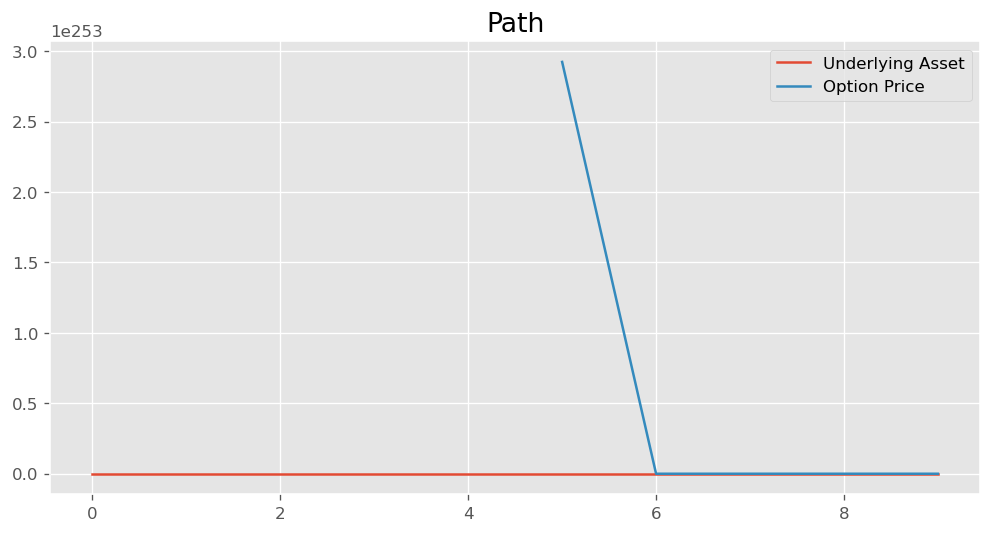

In [136]:
model.path_plot(hestonSim)

In [69]:
2*k*theta >= xi**2 # if True then vt  is strictly positive

True